
1. Write a Python program to perform global pairwise sequence alignment using dynamic programming. Any recursive form is forbidden.

2. Write a Python program to perform local pairwise sequence alignment using dynamic programming. Any recursive form is forbidden.

3. (bonus) Given two sequences of length N, could you use a 2 x N array to solve the above two problems?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class SequenceAlignment:
    def __init__(self, seq1, seq2, alignment_type, indel_score=-2, match_score=1):
        assert alignment_type in ["Local", "Global"]
        self.seq1 = seq1
        self.seq2 = seq2
        self.indel_score = indel_score
        self.match_score = match_score
        self.alignment_type = alignment_type

        # 用於視覺化方向
        self.direction_list  = ["→", "↓", "↘"]

        # 對Global 和 Local有些許不同
        self.init_dataframes()
        self.dynamic_update_dataframes()

        if alignment_type == "Global":
            self.globel_alignment()
        elif alignment_type == "Local":
            self.local_alignment()
        self.print_alignments()

    def init_dataframes(self):

        self.step_df = pd.DataFrame("", index=["X"] + list(self.seq1), columns=["X"] + list(self.seq2))
        self.score_df = pd.DataFrame(0, index=["X"] + list(self.seq1), columns=["X"] + list(self.seq2))
        if self.alignment_type == "Global":
            self.score_df.iloc[:, 0] = self.indel_score * np.arange(len(self.seq1) + 1)
            self.score_df.iloc[0, :] = self.indel_score * np.arange(len(self.seq2) + 1)

        self.step_df.iloc[1:, 0] = self.direction_list[1] #  ↓
        self.step_df.iloc[0, 1:] = self.direction_list[0] #  →


    def dynamic_update_dataframes(self):
        for ind1 in range(1, len(self.seq1)+1):
            for ind2 in range(1, len(self.seq2)+1):
                # 計算三種情況的分數
                score_list = [self.score_df.iloc[ind1, ind2-1] + self.indel_score,
                             self.score_df.iloc[ind1-1, ind2] + self.indel_score,
                             self.score_df.iloc[ind1-1, ind2-1] + (self.match_score if self.seq1[ind1-1] == self.seq2[ind2-1] else -self.match_score)]
                # 找最大值
                max_score = max(score_list)

                # 紀錄分數和方向

                self.step_df.iloc[ind1, ind2] = self.direction_list[score_list.index(max_score)]
                if self.alignment_type == "Local":
                    max_score = max(score_list+[0])
                self.score_df.iloc[ind1, ind2] = max_score

    def globel_alignment(self):
        alignment_seq1 = ""
        alignment_seq2 = ""
        self.path_df = self.step_df.copy()
        self.path_df[:] = False
        ind1, ind2 = len(self.seq1), len(self.seq2)
        while ind1 > 0 or ind2 > 0:
            current_direction = self.step_df.iloc[ind1, ind2]
            self.path_df.iloc[ind1, ind2] = True
            if current_direction == "↘":
                alignment_seq1 = self.step_df.index[ind1] + alignment_seq1
                alignment_seq2 = self.step_df.columns[ind2] + alignment_seq2
                ind1 -= 1
                ind2 -= 1

            elif current_direction == "→": # seq1不動seq2動 故扣seq2
                alignment_seq1 = "-" + alignment_seq1
                alignment_seq2 = self.step_df.columns[ind2] + alignment_seq2
                ind2 -= 1

            elif current_direction == "↓": # seq2不動seq1動 故扣seq1
                alignment_seq1 = self.step_df.index[ind1] + alignment_seq1
                alignment_seq2 = "-" + alignment_seq2
                ind1 -= 1

        # 找出match到的
        match_bar = "".join(["|" if c1 == c2 else " " for c1, c2 in zip(alignment_seq1, alignment_seq2)])
        self.alignment_list = [[alignment_seq1, match_bar, alignment_seq2]]

    def local_alignment(self):
        # 注意得分矩陣上可能有多處同分
        max_score =self.score_df.max().max()
        max_x, max_y = np.where(self.score_df == max_score)
        self.alignment_list = []
        self.path_df = self.step_df.copy()
        self.path_df[:] = False
        for ind1, ind2 in zip(max_x, max_y):

            alignment_seq1 = ""
            alignment_seq2 = ""

            while self.score_df.iloc[ind1, ind2] != 0:
                self.path_df.iloc[ind1, ind2] = True

                current_direction = self.step_df.iloc[ind1, ind2]
                if current_direction == "↘":
                    alignment_seq1 = self.step_df.index[ind1] + alignment_seq1
                    alignment_seq2 = self.step_df.columns[ind2] + alignment_seq2
                    ind1 -= 1
                    ind2 -= 1

                elif current_direction == "→": # seq1不動seq2動 故扣seq2
                    alignment_seq1 = "-" + alignment_seq1
                    alignment_seq2 = self.step_df.columns[ind2] + alignment_seq2
                    ind2 -= 1

                elif current_direction == "↓": # seq2不動seq1動 故扣seq1
                    alignment_seq1 = self.step_df.index[ind1] + alignment_seq1
                    alignment_seq2 = "-" + alignment_seq2
                    ind1 -= 1

            space_num = abs(ind1 - ind2)

            if ind1 < ind2: # seq1小值對到seq2大值 代表seq1前面補空格
                seq1 = ' '*space_num + self.seq1
                seq2 = self.seq2 + ' '*space_num

            elif ind1 > ind2: # seq2小值對到seq1大值 代表seq2前面補空格
                seq1 = self.seq1 + ' '*space_num
                seq2 = ' '*space_num + self.seq2

            # 找出match到的，因為seq有錯開所以可用一樣的程式碼
            match_bar = "".join(["|" if c1 == c2 else " " for c1, c2 in zip(seq1, seq2)])
            self.alignment_list.append([seq1, match_bar, seq2])

    def print_alignments(self):
        for ind, (seq1, match_bar, seq2) in enumerate(self.alignment_list):
            print(f"{self.alignment_type} Alignment {ind+1}:\n{seq1}\n{match_bar}\n{seq2}\n")


    def heatmap(self):
        plt.figure(figsize=(12, 10))
        mask = self.path_df.astype("bool")
        ax = sns.heatmap(self.score_df,
                         cmap="crest",
                         annot=self.step_df,
                         fmt="",
                         square=True,
                         #linewidths=.6,
                         cbar_kws={"label": "Score","shrink": 0.6},
                         annot_kws={"color": "black", "alpha":0.9})
        plt.title(f"{self.alignment_type} Sequence Alignment")
        plt.tick_params(axis='x', which='both', labeltop=True, top=True, labelbottom=False, bottom=False)
        ax.xaxis.set_label_position('top')
        plt.xlabel("Sequence 2")
        plt.ylabel("Sequence 1")
        for i in range(len(ax.texts)):
            if mask.values.flatten()[i]:
                ax.texts[i].set_color("white")
                ax.texts[i].set_fontsize(13)

        plt.show()


Global Alignment 1:
--T--CC-CAGTTATGT-CAGGGG--A---CA---C
  |  || | ||  | | |||  |  |   ||   |
AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC



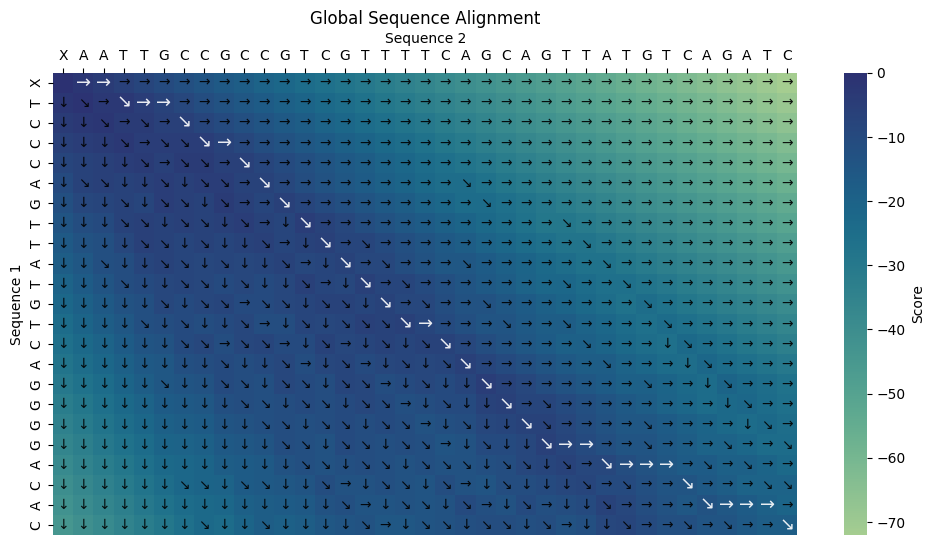

In [3]:
seq1 = "TCCCAGTTATGTCAGGGGACAC"
seq2 = "AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC"

SA_global = SequenceAlignment(seq1, seq2, "Global")
SA_global.heatmap()

Local Alignment 1:
                  TCCCAGTTATGTCAGGGGACAC
                     ||||||||||||       
AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC                  



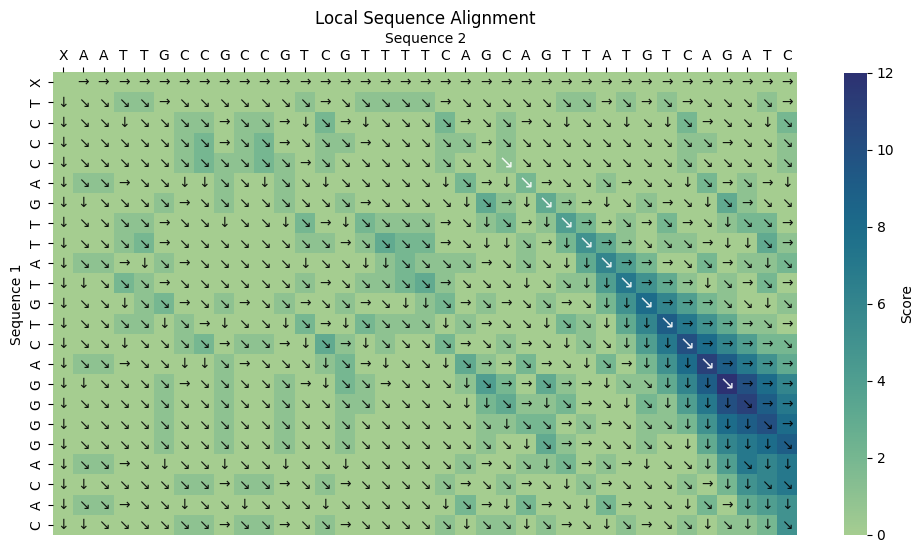

In [166]:
SA_local = SequenceAlignment(seq1, seq2, "Local")
SA_local.heatmap()